# Example Spatio-Temporal Strategy
@author: Max Felius
@date: 05/05/2021



In [1]:
#imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os, sys, time
import re, datetime
from scipy import spatial
from tqdm import tqdm

#import personal functions
sys.path.extend(os.path.join(os.getcwd(),'sinkhole_functions'))
from sinkhole_functions.functions import *
from sinkhole_functions.influence_functions import *
from sinkhole_functions.spatio_temporal_functions import *

# Loading dataset

In [2]:
folder = ''
# filename1 = 'Sinkhole_Implemented_Dataset_Franciscaner_05052021.csv'
filename1 = 'Implemented_linear_Franciscanerstraat_sinkhole_final.csv'
location_file = 'sinkhole_kerkrade.csv'

#load the data
data = pd.read_csv(os.path.join(folder,filename1))
location = pd.read_csv(os.path.join(folder,location_file))

#get information from pandas df
headers = list(data)
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pnt_lon, data.pnt_lat))
data_gdf.crs = 'epsg:4326' #wgs84
data_gdf = data_gdf.to_crs('epsg:28992') #to Amersfoort Rijksdriehoekenstelsel
location_gdf = gpd.GeoDataFrame(location, geometry=gpd.points_from_xy(location.longitude, location.latitude))
location_gdf.crs = 'epsg:4326' #wgs84
location_gdf = location_gdf.to_crs('epsg:28992') # to Amersfoort Rijksdriehoekenstelsel

#select point locations
rdx = data_gdf.geometry.x.values
rdy = data_gdf.geometry.y.values

#make the kdtree for quick subset creation
rd_data = np.concatenate((rdx.reshape(len(rdx),1),rdy.reshape(len(rdy),1)),axis=1)
tree = spatial.cKDTree(rd_data)

#save the data
save_folder = 'figures1_new'

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

# Setting Parameters

In [3]:
R = 35 #radius of influence of the sinkhole

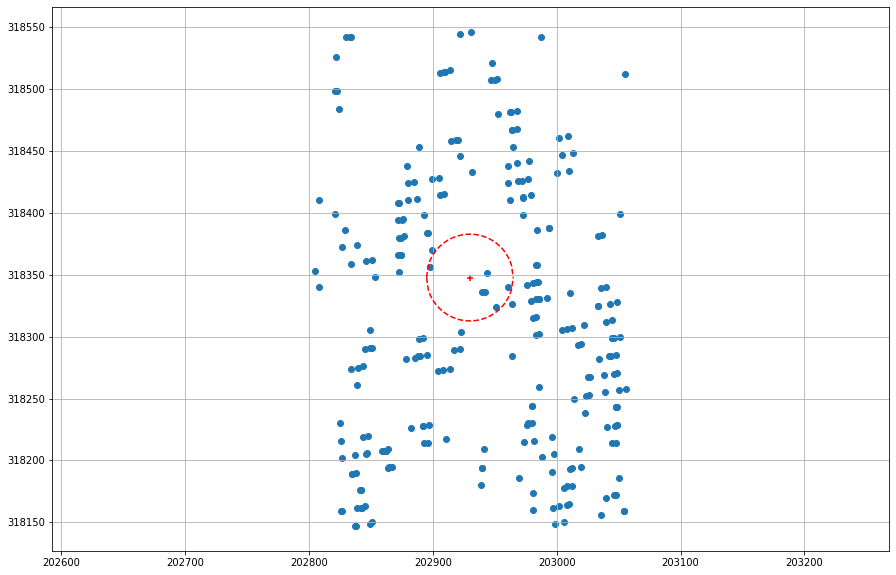

In [4]:
#placing the sinkhole 
plt.figure(figsize=(15,10))
plt.scatter(data['pnt_rdx'].values,data['pnt_rdy'].values)
x0 = location_gdf.geometry.x.values
y0 = location_gdf.geometry.y.values

x_test = np.linspace(x0-R,x0+R,50)

plt.scatter(x0,y0,c='r',marker='+')
plt.plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
plt.plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

plt.axis('equal')
plt.grid(True);

In [5]:
#obtain limits dataset
xmin = np.min(rdx)
xmax = np.max(rdx)
ymin = np.min(rdy)
ymax = np.max(rdy)

#Define the grid for evaluation
n = 20
x_range = np.linspace(xmin,xmax,n)
y_range = np.linspace(ymin,ymax,n)

xv, yv = np.meshgrid(x_range,y_range)

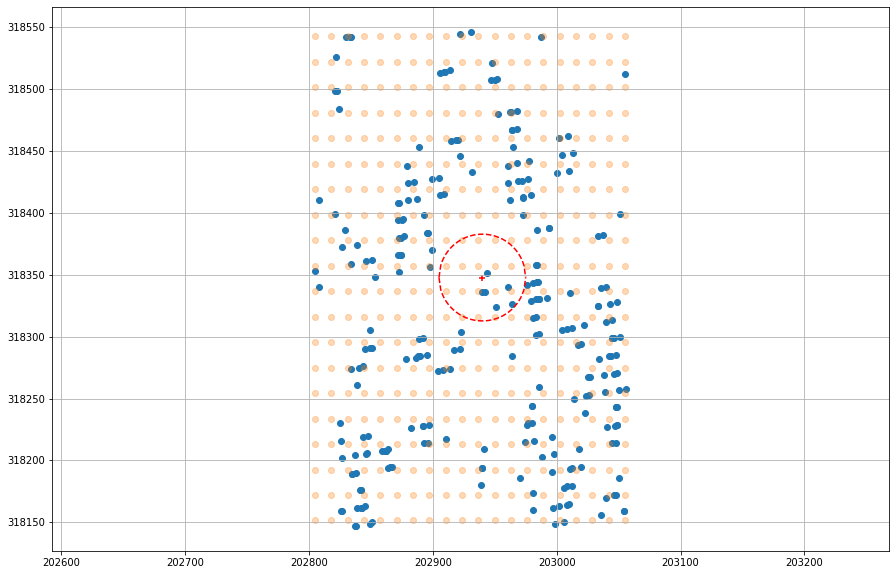

In [6]:
#placing the sinkhole 
plt.figure(figsize=(15,10))
plt.scatter(data['pnt_rdx'].values,data['pnt_rdy'].values)
x0 = location_gdf.geometry.x.values + 10
y0 = location_gdf.geometry.y.values

x_test = np.linspace(x0-R,x0+R,50)

plt.scatter(x0,y0,c='r',marker='+')
plt.plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
plt.plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

#plot grid
plt.scatter(xv.ravel(),yv.ravel(),alpha=0.3)

plt.axis('equal')
plt.grid(True);

# Setting up the kinematic model for testing the sinkhole

In [7]:
# setting up variables
xv_u = xv.ravel()
yv_u = yv.ravel()
n_points = len(xv_u)
n_time = 10 #10 epochs tested
epochs = np.array(get_sentinel_days(list(data_gdf))) #get all the sentinel epochs
#define the time window of a sinkhole
steps = np.arange(0,len(epochs)-n_time,1)
n_steps = len(steps)

# pre allocate space for variable
xhat_save = np.zeros((n_points,n_steps))
qxhat_save = np.zeros((n_points,n_steps))

#start the grid-wise search
for i in tqdm(range(n_points),):
    #select new center point
    xi = xv_u[i]
    yi = yv_u[i]
    
    #select subset
    subset = tree.query_ball_point(([xi,yi]),r=R)
    
    #start test
    if len(subset) <= 1: 
        #subset is empty
        for iii in range(n_steps):
            xhat_save[i,iii] = np.nan
            qxhat_save[i,iii] = np.nan
    else:
        #compute distance towards center (radius)
        xp = data_gdf.geometry.x.values[subset]
        yp = data_gdf.geometry.y.values[subset]
        
        r = np.sqrt((xp-xi)**2 + (yp-yi)**2)
        
        for ii in steps:
            ii = int(ii)
            #get relative days
            selected_epochs = epochs[ii:ii+n_time]
            t, start_day = get_delta_days(selected_epochs)
            
            y = data_gdf[selected_epochs].iloc[subset].values
            
            #calculate subsidence velocity
            t_vector, y_vector, r_vector = create_matching_len(t,y,r)
            
            xhat, Qxhat, fit = kinematic_model(R,r_vector,y_vector,t_vector)
            
            #save the parameters
            xhat_save[i,ii] = xhat
            qxhat_save[i,ii] = Qxhat

100%|██████████| 400/400 [03:21<00:00,  1.98it/s]


In [8]:
#filter for extreme values
def filter_extremes(item,maxvalue=0.1,minvalue=0.0000001):
    if item == 0:
        return np.nan
    
    if item > maxvalue:
        return np.nan
#         return maxvalue
    if item < minvalue:
        return np.nan
#         return minvalue
    else:
        return item
    
def filter_extremes2(item,maxvalue=0.1,minvalue=0.0000001):
    if item == 0:
        return np.nan
    
    if item > maxvalue:
        return np.nan
#         return maxvalue
    if item < minvalue:
        return np.nan
#         return minvalue
    else:
        return 1/item

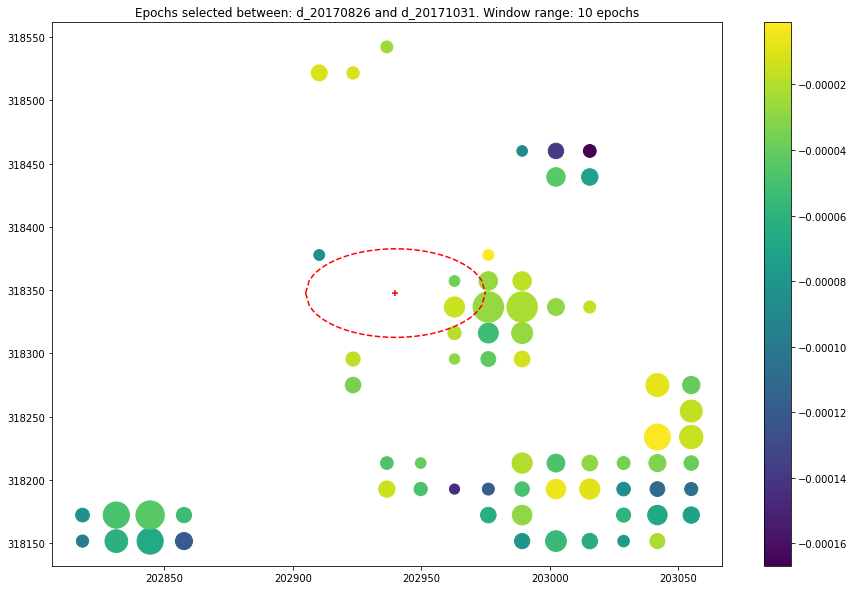

In [9]:
test_loc = 80

# qxhat_save[:,test_loc].ravel().reshape((len(xv_u),1))

filtered_qxhat = np.array(list(map(lambda e: filter_extremes2(e,maxvalue=1e-4,minvalue=0),qxhat_save[:,test_loc].ravel())))
filtered_v = list(map(lambda e: filter_extremes(e,maxvalue=0,minvalue=-0.1),xhat_save[:,test_loc].ravel()))


plt.figure(figsize=(15,10))

# h = plt.scatter(xv_u,yv_u,c=xhat_save[:,test_loc],s=filtered_qxhat/100)
h = plt.scatter(xv_u,yv_u,c=filtered_v,s=filtered_qxhat/100)
plt.scatter(x0,y0,c='r',marker='+')
plt.plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
plt.plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

plt.title(f'Epochs selected between: {epochs[test_loc]} and {epochs[test_loc+n_time]}. Window range: {n_time} epochs')
plt.colorbar(h);

# Interactive Investigation of the dataset

In [9]:
%matplotlib inline
# %matplotlib qt5
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

def g(test_loc):
    filtered_qxhat = np.array(list(map(lambda e: filter_extremes2(e,maxvalue=1e-4,minvalue=0),qxhat_save[:,test_loc].ravel())))
    filtered_v = list(map(lambda e: filter_extremes(e,maxvalue=-0.00015,minvalue=-1),xhat_save[:,test_loc].ravel()))
    
    plt.figure(2,figsize=(10,5))

    # h = plt.scatter(xv_u,yv_u,c=xhat_save[:,test_loc],s=filtered_qxhat/100)
    h = plt.scatter(xv_u,yv_u,c=filtered_v,s=filtered_qxhat/100)
    plt.scatter(x0,y0,c='r',marker='+')
    plt.plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
    plt.plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

    plt.title(f'Epochs selected between: {epochs[test_loc]} and {epochs[test_loc+n_time]}. Window range: {n_time} epochs\n')
    plt.colorbar(h)
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.show()

# interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
interactive_plot = interactive(g,test_loc=(0,len(epochs)-n_time-1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=68, description='test_loc', max=137), Output(layout=Layout(height='350px…

# Save Images

In [11]:
for i in np.arange(80,100,1):
    test_loc = i
    filtered_qxhat = np.array(list(map(lambda e: filter_extremes2(e,maxvalue=1e-4,minvalue=0),qxhat_save[:,test_loc].ravel())))
    filtered_v = np.array(list(map(lambda e: filter_extremes(e,maxvalue=0,minvalue=-0.001),xhat_save[:,test_loc].ravel())))
    
    plt.figure(figsize=(20,15))

    plt.scatter(xv.ravel(),yv.ravel(),alpha=0.1,label='Grid Point')
    plt.scatter(x0,y0,c='r',marker='+',label='Sinkhole Center')
    plt.plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
    plt.plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

    # h = plt.scatter(xv_u,yv_u,c=xhat_save[:,test_loc],s=filtered_qxhat/100)
    h = plt.scatter(xv_u,yv_u,c=filtered_v*1000,s=filtered_qxhat/100,vmin=-0.001*1000,vmax=0)
    plt.scatter(data['pnt_rdx'].values,data['pnt_rdy'].values,alpha=0.8,label='PS Point')
    
    
    plt.title(f'Epochs selected between: {epochs[test_loc]} and {epochs[test_loc+n_time]}. Window range: {n_time} epochs\n')
    cbar = plt.colorbar(h)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Subsidence Velocity [mm/day]', rotation=270)
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.xlabel('RD x [m]')
    plt.ylabel('RD y [m]')
    
    plt.savefig(os.path.join(save_folder,f'num{i}_WindowRange{n_time}_{epochs[test_loc]}_{epochs[test_loc+n_time]}.png'))
    plt.close('all')

In [12]:
import imageio

images = []

files = sorted(os.listdir(save_folder))

for file_name in files:
    print(file_name)
    if file_name.endswith('.png'):
            file_path = os.path.join(save_folder,file_name)
            images.append(imageio.imread(file_path))
            
imageio.mimsave(os.path.join(save_folder,'Animation_spatio_temporal.gif'),images,fps=2)
print('done')

num80_WindowRange10_d_20170826_d_20171031.png
num81_WindowRange10_d_20170901_d_20171106.png
num82_WindowRange10_d_20170907_d_20171112.png
num83_WindowRange10_d_20170913_d_20171118.png
num84_WindowRange10_d_20170919_d_20171124.png
num85_WindowRange10_d_20170925_d_20171130.png
num86_WindowRange10_d_20171001_d_20171206.png
num87_WindowRange10_d_20171013_d_20171218.png
num88_WindowRange10_d_20171019_d_20171224.png
num89_WindowRange10_d_20171025_d_20171230.png
num90_WindowRange10_d_20171031_d_20180105.png
num91_WindowRange10_d_20171106_d_20180111.png
num92_WindowRange10_d_20171112_d_20180117.png
num93_WindowRange10_d_20171118_d_20180129.png
num94_WindowRange10_d_20171124_d_20180204.png
num95_WindowRange10_d_20171130_d_20180210.png
num96_WindowRange10_d_20171206_d_20180216.png
num97_WindowRange10_d_20171218_d_20180222.png
num98_WindowRange10_d_20171224_d_20180228.png
num99_WindowRange10_d_20171230_d_20180306.png
done
